In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='lAIrC0qEnlTliq3lvSG3_3-hFUzbRPLHfE8_yAD_9YN0',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudeoil-donotdelete-pr-fbncvdmu8m5wnw'
object_key = 'Crude Oil Prices Daily.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dv = pd.read_csv(body)
dv.head()


,Date,Closing Value
0,01-02-1986,25.56
1,01-03-1986,26.00
2,01-06-1986,26.53
3,01-07-1986,25.85
4,01-08-1986,25.87


In [3]:
dv.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [4]:
dv.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [5]:
dv.dropna(axis=0,inplace=True)

In [6]:
dv.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [7]:
dv_oil=dv.reset_index()['Closing Value']

In [8]:
dv_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
dv_oil=scaler.fit_transform(np.array(dv_oil).reshape(-1,1))


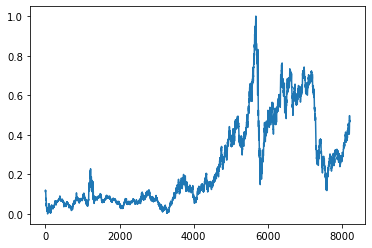

In [10]:
plt.plot(dv_oil)

In [11]:
training_size=int(len(dv_oil)*0.65)
test_size=len(dv_oil)-training_size
train_data,test_data=dv_oil[0:training_size,:],dv_oil[training_size:len(dv_oil),:1]

In [12]:
training_size,test_size

(5340, 2876)

In [13]:
train_data.shape

(5340, 1)

In [14]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX), np.array(dataY) 

In [15]:
time_step = 10
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [16]:
print(x_train.shape), print(y_train.shape)

(5329, 10)
(5329,)


(None, None)

In [17]:
print(x_test.shape), print(y_test.shape)

(2865, 10)
(2865,)


(None, None)

In [18]:
x_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.36731823, 0.35176958, 0.36080261, ..., 0.36391234, 0.37042796,
        0.37042796],
       [0.35176958, 0.36080261, 0.35354657, ..., 0.37042796, 0.37042796,
        0.37879461],
       [0.36080261, 0.35354657, 0.35295424, ..., 0.37042796, 0.37879461,
        0.37916482]])

In [19]:
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test =x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

# Importing The Model Building Libraries

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Initializing The Model

In [21]:
model= Sequential()

# Adding LSTM Layers

In [22]:
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))

# Adding Output Layers

In [23]:
model.add(Dense(1))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


# Configure The Learning Process


In [25]:
model.compile(loss='mean_squared_error',optimizer='adam')

# Train The Model


In [26]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
84/84 [==============================] - 7s 34ms/step - loss: 0.0018 - val_loss: 8.7909e-04
Epoch 2/50
84/84 [==============================] - 2s 23ms/step - loss: 1.2715e-04 - val_loss: 7.7700e-04
Epoch 3/50
84/84 [==============================] - 2s 23ms/step - loss: 1.2739e-04 - val_loss: 0.0013
Epoch 4/50
84/84 [==============================] - 2s 23ms/step - loss: 1.3033e-04 - val_loss: 8.2006e-04
Epoch 5/50
84/84 [==============================] - 2s 21ms/step - loss: 1.3939e-04 - val_loss: 8.3564e-04
Epoch 6/50
84/84 [==============================] - 2s 21ms/step - loss: 1.2103e-04 - val_loss: 0.0012
Epoch 7/50
84/84 [==============================] - 2s 24ms/step - loss: 1.2681e-04 - val_loss: 0.0010
Epoch 8/50
84/84 [==============================] - 2s 22ms/step - loss: 1.2228e-04 - val_loss: 8.7145e-04
Epoch 9/50
84/84 [==============================] - 2s 19ms/step - loss: 1.1984e-04 - val_loss: 8.0682e-04
Epoch 10/50
84/84 [==============================] - 

# Model Evaluation


In [27]:
train_predict=scaler.inverse_transform(train_data) 
test_predict=scaler.inverse_transform(test_data)
### Calculate RMSE performance metrics
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(train_data,train_predict))

29.347830443269938

# Save The Model


In [28]:
from tensorflow.keras.models import load_model

In [29]:
model.save("crude_oil.hs")

2022-11-14 16:27:01.050452: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: crude_oil.hs/assets


INFO:tensorflow:Assets written to: crude_oil.hs/assets


# Test The Model


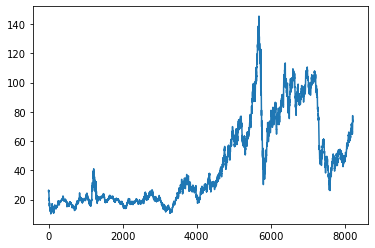

In [30]:
### Plotting
look_back=10
trainpredictPlot = np.empty_like(dv_oil)
trainpredictPlot[:, :]= np.nan
trainpredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictplot = np.empty_like(dv_oil)
testPredictplot[:,: ] = np.nan
testPredictplot[look_back:len(test_predict)+look_back, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dv_oil))
plt.show()

In [31]:
len(test_data)

2876

In [32]:
x_input=test_data[2866:].reshape(1,-1)
x_input.shape

(1, 10)

In [33]:
temp_input=list(x_input) 
temp_input=temp_input[0].tolist()

In [34]:
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [35]:
lst_output=[]
n_steps=10
i=0
while(i<10):
    if(len(temp_input)>10):
#print(temp_input)
       x_input=np.array(temp_input[1:]) 
       print("{} day input {}".format(i,x_input))
       x_input=x_input.reshape(1,-1)
       x_input = x_input.reshape((1, n_steps, 1)) #print(x_input)
       yhat = model.predict(x_input, verbose=0)
       print("{} day output {}".format(i,yhat))
       temp_input.extend(yhat[0].tolist())
       temp_input=temp_input[1:] #print(temp_input)
       lst_output.extend(yhat.tolist())
       i=i+1
    else:
       x_input = x_input.reshape((1, n_steps,1))
       yhat = model.predict(x_input, verbose=0)
       print(yhat[0])
       temp_input.extend(yhat[0].tolist()) 
       print(len(temp_input))
       lst_output.extend(yhat.tolist())
       i=i+1

[0.4727359]
11
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.47273591]
1 day output [[0.4741107]]
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.47273591 0.47411069]
2 day output [[0.47500542]]
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.47273591 0.47411069 0.47500542]
3 day output [[0.47529083]]
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.47273591 0.47411069 0.47500542 0.47529083]
4 day output [[0.47535536]]
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.47273591
 0.47411069 0.47500542 0.47529083 0.47535536]
5 day output [[0.4752194]]
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.47273591 0.47411069
 0.47500542 0.47529083 0.47535536 0.4752194 ]
6 day output [[0.4750311]]
7 day input [0.46497853 0.47038353 0.47149415 0.47273591 0.47411069 0.

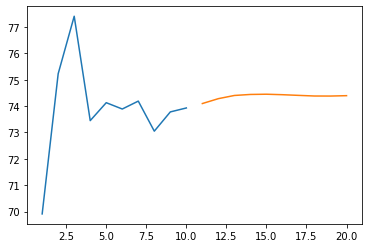

In [36]:
day_new=np.arange(1,11) 
day_pred=np.arange(11,21)
len(dv_oil)
plt.plot(day_new, scaler.inverse_transform(dv_oil[8206:])) 
plt.plot(day_pred, scaler.inverse_transform(lst_output))

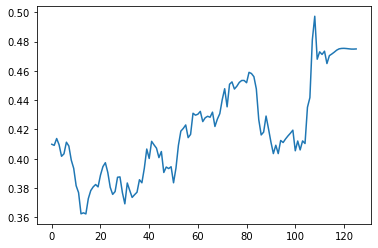

In [37]:
df3=dv_oil.tolist() 
df3.extend(lst_output) 
plt.plot(df3[8100:])

In [38]:
df3=scaler.inverse_transform(df3).tolist()

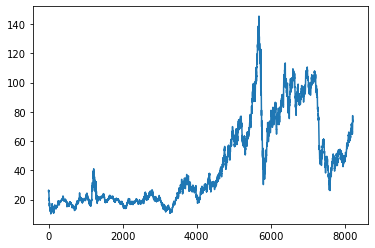

In [39]:
plt.plot(scaler.inverse_transform(dv_oil))

# IBM Deployment

In [40]:
!pip install watson-machine-learning-client

     |████████████████████████████████| 538 kB 14.8 MB/s eta 0:00:01


In [41]:
from ibm_watson_machine_learning import APIClient
wml_credentials={"url":"https://us-south.ml.cloud.ibm.com",
                 "apikey": "0SdsONR5sZj9y1_25I00H_RSvHbY7lErP-m_F5T3Knif"
}
client=APIClient(wml_credentials)

In [42]:
client

In [43]:
def guid_space_name(client,crude_oil):
    space=client.spaces.get_details()
    return(next(item for item in space['resources']if item['entity']['name']==crude_oil)['metadata']['id'])

In [45]:
space_uid=guid_space_name(client,'crude_oil')
print("space uid"+space_uid)

space uidc156c9ca-1124-4991-8d99-4095be07a387


In [46]:
client.set.default_space(space_uid)

'SUCCESS'

In [47]:
client.software_specifications.list(200)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

In [48]:
software_space_uid=client.software_specifications.get_uid_by_name('tensorflow_rt22.1-py3.9')

In [49]:
software_space_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [50]:
model_details=client.repository.store_model(model='crude_oil.hs',meta_props={
    client.repository.ModelMetaNames.NAME:" CNN Model Building",
    client.repository.ModelMetaNames.TYPE:'tensorflow_2.7',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})

In [53]:
model_id=client.repository.get_model_id(model_details)

In [54]:
model_id

'5a4b4001-da7a-4195-a3be-18870f6c524f'

In [55]:
client.repository.download(model_id,'crude_oil')

Successfully saved model content to file: 'crude_oil'


'/home/wsuser/work/crude_oil'